# Exploratory analysis

TODO:
- Understanding the reason for fake profiles can bring insight on how to catch them (could be trivial with prior knowledge, e.g., SEO hacking => URLs)
- Study different cases (e.g. author publishing with empty orcid, author publishing but not on OpenAIRE, etc.)
- Temporal dimension; is it of any use?
- Can we access private info thanks to the OpenAIRE-ORCID agreement? No.


In [1]:
import glob
import ast

from datetime import datetime
import pytz

import tldextract # parse URLs

import ssl # needed because nltk.download down here fires an error
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import numpy as np
import pandas as pd

import antispam
import profanity_check

import seaborn as sns
import plotly
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.express as px

init_notebook_mode(connected=True)
TOP_N = 0
TOP_RANGE = [0, 0]

def set_top_n(n):
    global TOP_N, TOP_RANGE
    TOP_N = n
    TOP_RANGE = [-.5, n - 1 + .5]
    
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to /Users/andrea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Notable solid ORCID iDs for explorative purposes:

In [2]:
AM = '0000-0002-5193-7851'
PP = '0000-0002-8588-4196'


Notable anomalies:

In [3]:
JOURNAL = '0000-0003-1815-5732'
NOINFO = '0000-0001-5009-2052'
VALID_NO_OA = '0000-0002-5154-6404' # True profile, but not in OpenAIRE
WORK_MISUSE = '0000-0001-7870-1120'
# todo: find group-shared ORCiD, if possible

Notable fake ORCID iDs:

In [4]:
FAKE_HEAP = {
    'scaffold': '0000-0001-5004-7761',
    'whatsapp': '0000-0001-6997-9470',
    'penis': '0000-0002-3399-7287',
    'bitcoin': '0000-0002-7518-6845',
    'fitness': '0000-0002-1234-835X',    # URL record + employment
    'cannabis': '0000-0002-9025-8632',   # URL > 70 + works (now REMOVED)
    'plumber': '0000-0002-1700-8311',    # URL > 10 + works
    'furniture': '0000-0001-7478-4539',
    'cleaners': '0000-0002-7392-3792'
}

Load the dataset

In [5]:
parts = glob.glob('../data/processed/dataset.pkl.*')

df = pd.concat((pd.read_pickle(part) for part in sorted(parts)))
df.head(5)

orcid  verified_email  verified_primary_email given_names  \
0  0000-0001-6097-3953           False                   False        <NA>   
1  0000-0001-6112-5550            True                    True        <NA>   
2  0000-0001-6152-2695            True                    True        <NA>   
3  0000-0001-6220-5683            True                    True        <NA>   
4  0000-0001-7071-8294            True                    True        <NA>   

  family_name biography                 other_names primary_email keywords  \
0        <NA>      <NA>                         NaN          <NA>      NaN   
1        <NA>      <NA>  [v.i. yurtaev; v. yurtaev]          <NA>      NaN   
2        <NA>      <NA>                         NaN          <NA>      NaN   
3        <NA>      <NA>                         NaN          <NA>      NaN   
4        <NA>      <NA>                         NaN          <NA>      NaN   

  external_ids education                                         employment  \
0          NaN       NaN                                                NaN   
1          NaN       NaN  [[professor, peoples friendship university of ...   
2          NaN       NaN                                                NaN   
3          NaN       NaN  [[research scientist, new york university abu ...   
4          NaN       NaN  [[researcher (academic), universidad de zarago...   

   n_works works_source                  activation_date  \
0        0          NaN 2018-03-02 09:29:16.528000+00:00   
1        0          NaN 2018-04-03 07:50:23.358000+00:00   
2        0          NaN 2019-12-11 15:31:56.388000+00:00   
3        0          NaN 2015-08-18 12:36:45.307000+00:00   
4        0          NaN 2014-03-10 13:22:01.966000+00:00   

                  last_update_date  n_doi  n_arxiv  n_pmc  n_other_pids  \
0 2018-03-02 09:43:07.551000+00:00      0        0      0             0   
1 2020-03-18 09:42:44.753000+00:00      0        0      0             0   
2 2020-01-28 15:34:17.309000+00:00      0        0      0             0   
3 2020-09-23 13:37:54.180000+00:00      0        0      0             0   
4 2016-06-14 22:17:54.470000+00:00      0        0      0             0   

   label primary_email_domain other_email_domains url_domains  n_emails  \
0  False                  NaN                 NaN         NaN      <NA>   
1  False                  NaN                 NaN         NaN      <NA>   
2  False                  NaN                 NaN         NaN      <NA>   
3  False                  NaN                 NaN         NaN      <NA>   
4  False                  NaN                 NaN         NaN      <NA>   

   n_urls  n_ids  n_keywords  n_education  n_employment  
0    <NA>   <NA>        <NA>         <NA>          <NA>  
1    <NA>   <NA>        <NA>         <NA>             1  
2    <NA>   <NA>        <NA>         <NA>          <NA>  
3    <NA>   <NA>        <NA>         <NA>             1  
4    <NA>   <NA>        <NA>         <NA>             2

Notable profiles inspection

In [6]:
df[df['orcid'] == AM]

orcid  verified_email  verified_primary_email  \
3073261  0000-0002-5193-7851            True                    True   

        given_names family_name  \
3073261      andrea    mannocci   

                                                 biography other_names  \
3073261  data scientist & researcher; scholarly knowled...         NaN   

                       primary_email  \
3073261  andrea.mannocci@isti.cnr.it   

                                                  keywords  \
3073261  [science of science, open science, research in...   

                              external_ids  \
3073261  [[scopus author id, 55233589900]]   

                                                 education  \
3073261  [[information engineering, ph.d., università d...   

                                                employment  n_works  \
3073261  [[research associate, istituto di scienza e te...       37   

                                              works_source  \
3073261  [scopus - elsevier, crossref metadata search, ...   

                         activation_date                 last_update_date  \
3073261 2017-09-12 14:28:33.467000+00:00 2021-03-17 15:40:07.776000+00:00   

         n_doi  n_arxiv  n_pmc  n_other_pids  label primary_email_domain  \
3073261     34        0      0            60   True          isti.cnr.it   

        other_email_domains                             url_domains  n_emails  \
3073261                 NaN  [github.io, twitter.com, linkedin.com]      <NA>   

         n_urls  n_ids  n_keywords  n_education  n_employment  
3073261       3      1           5            4             5

In [7]:
df[df['orcid'] == FAKE_HEAP['whatsapp']]

orcid  verified_email  verified_primary_email  \
9887272  0000-0001-6997-9470            True                    True   

        given_names family_name biography other_names primary_email  \
9887272       other    whatsapp      <NA>         NaN          <NA>   

                                                  keywords external_ids  \
9887272  [whatsapp gb apk, whatsapp gb, whatsapp gb bai...          NaN   

        education employment  n_works works_source  \
9887272       NaN        NaN        0          NaN   

                         activation_date                 last_update_date  \
9887272 2020-10-07 10:37:12.237000+00:00 2020-10-08 02:32:03.935000+00:00   

         n_doi  n_arxiv  n_pmc  n_other_pids  label primary_email_domain  \
9887272      0        0      0             0  False                  NaN   

        other_email_domains  \
9887272                 NaN   

                                               url_domains  n_emails  n_urls  \
9887272  [otherwhatsapp.com, im-creator.com, facebook.c...      <NA>      27   

         n_ids  n_keywords  n_education  n_employment  
9887272   <NA>           4         <NA>          <NA>

In [8]:
df.count()

orcid                     10989649
verified_email            10989649
verified_primary_email    10989649
given_names               10959039
family_name               10671715
biography                   354015
other_names                 554684
primary_email               124722
keywords                    649637
external_ids               1308598
education                  2441645
employment                 2680488
n_works                   10989649
works_source               2740939
activation_date           10989649
last_update_date          10989649
n_doi                     10989649
n_arxiv                   10989649
n_pmc                     10989649
n_other_pids              10989649
label                     10989649
primary_email_domain        124722
other_email_domains          48615
url_domains                 715067
n_emails                     48615
n_urls                      715067
n_ids                      1308598
n_keywords                  649637
n_education         

In [9]:
df['orcid'].describe()

count                10989649
unique               10989649
top       0000-0002-4206-6417
freq                        1
Name: orcid, dtype: object

## Primary email

In [10]:
df['primary_email'].describe()

count               124722
unique              124718
top       maykin@owasp.org
freq                     2
Name: primary_email, dtype: object

Dupe emails

In [11]:
df['primary_email'].dropna().loc[df['primary_email'].duplicated()]

1681787       opercin@erbakan.edu.tr
5590332     patrick.davey@monash.edu
9316843             maykin@owasp.org
10375852       andycheng2026@163.com
Name: primary_email, dtype: string

In [12]:
df[df['primary_email'] == 'maykin@owasp.org']

orcid  verified_email  verified_primary_email  \
7543981  0000-0002-0836-2271            True                    True   
9316843  0000-0001-9855-1676            True                    True   

        given_names family_name biography other_names     primary_email  \
7543981      maykin    warasart      <NA>         NaN  maykin@owasp.org   
9316843      maykin    warasart      <NA>         NaN  maykin@owasp.org   

        keywords external_ids education employment  n_works works_source  \
7543981      NaN          NaN       NaN        NaN        0          NaN   
9316843      NaN          NaN       NaN        NaN        0          NaN   

                         activation_date                 last_update_date  \
7543981 2020-09-15 04:43:55.709000+00:00 2020-09-15 05:17:28.509000+00:00   
9316843 2020-10-23 17:51:51.925000+00:00 2021-01-01 15:00:52.053000+00:00   

         n_doi  n_arxiv  n_pmc  n_other_pids  label primary_email_domain  \
7543981      0        0      0             0  False            owasp.org   
9316843      0        0      0             0  False            owasp.org   

           other_email_domains url_domains  n_emails  n_urls  n_ids  \
7543981            [dga.or.th]         NaN         1    <NA>   <NA>   
9316843  [dga.or.th, ieee.org]         NaN         2    <NA>   <NA>   

         n_keywords  n_education  n_employment  
7543981        <NA>         <NA>          <NA>  
9316843        <NA>         <NA>          <NA>

In [13]:
df[df['primary_email'] == 'opercin@erbakan.edu.tr']

orcid  verified_email  verified_primary_email  \
347852   0000-0002-2232-9638            True                    True   
1681787  0000-0003-0033-0918            True                    True   

        given_names family_name biography other_names           primary_email  \
347852        osman      perçin      <NA>         NaN  opercin@erbakan.edu.tr   
1681787       osman      perçin      <NA>         NaN  opercin@erbakan.edu.tr   

        keywords external_ids education  \
347852       NaN          NaN       NaN   
1681787      NaN          NaN       NaN   

                                                employment  n_works  \
347852                                                 NaN        0   
1681787  [[, necmettin erbakan university, konya, , tr,...        0   

        works_source                  activation_date  \
347852           NaN 2015-01-12 13:47:55.549000+00:00   
1681787          NaN 2015-10-13 05:47:12.014000+00:00   

                        last_update_date  n_doi  n_arxiv  n_pmc  n_other_pids  \
347852  2020-01-27 07:38:24.269000+00:00      0        0      0             0   
1681787 2020-12-25 13:52:03.976000+00:00      0        0      0             0   

         label primary_email_domain other_email_domains url_domains  n_emails  \
347852   False       erbakan.edu.tr                 NaN         NaN      <NA>   
1681787  False       erbakan.edu.tr                 NaN         NaN      <NA>   

         n_urls  n_ids  n_keywords  n_education  n_employment  
347852     <NA>   <NA>        <NA>         <NA>          <NA>  
1681787    <NA>   <NA>        <NA>         <NA>             1

In [14]:
df[df['primary_email'] == 'patrick.davey@monash.edu']

orcid  verified_email  verified_primary_email  \
954085   0000-0002-9158-1757            True                    True   
5590332  0000-0002-8774-0030            True                    True   

        given_names family_name biography other_names  \
954085      patrick       davey      <NA>         NaN   
5590332     patrick       davey      <NA>         NaN   

                    primary_email  \
954085   patrick.davey@monash.edu   
5590332  patrick.davey@monash.edu   

                                                  keywords external_ids  \
954085   [inorganic chemistry, radiopharmaceuticals, ra...          NaN   
5590332                                                NaN          NaN   

        education                                         employment  n_works  \
954085        NaN  [[phd student, monash university, melbourne, ,...        0   
5590332       NaN  [[phd student, monash university, melbourne, v...        1   

        works_source                  activation_date  \
954085           NaN 2019-05-09 23:01:02.170000+00:00   
5590332   [crossref] 2018-09-11 10:47:10.997000+00:00   

                        last_update_date  n_doi  n_arxiv  n_pmc  n_other_pids  \
954085  2019-08-20 03:00:17.844000+00:00      0        0      0             0   
5590332 2021-02-09 06:21:44.138000+00:00      1        0      0             0   

         label primary_email_domain other_email_domains url_domains  n_emails  \
954085   False           monash.edu                 NaN         NaN      <NA>   
5590332   True           monash.edu                 NaN         NaN      <NA>   

         n_urls  n_ids  n_keywords  n_education  n_employment  
954085     <NA>   <NA>           4         <NA>             1  
5590332    <NA>   <NA>        <NA>         <NA>             1

In [15]:
df['primary_email_domain'].describe()

count        124722
unique        17160
top       gmail.com
freq          26750
Name: primary_email_domain, dtype: object

In [16]:
top_primary_emails = df[['primary_email_domain', 'orcid']]\
                .groupby('primary_email_domain')\
                .count()\
                .sort_values('orcid', ascending=False)
top_primary_emails

orcid
primary_email_domain       
gmail.com             26750
hotmail.com            3801
yahoo.com              2625
163.com                2132
yuhs.ac                1134
...                     ...
imf.csic.es               1
imf.org                   1
imfd.tu-freiberg.de       1
imft.fr                   1
zzuli.edu.cn              1

[17160 rows x 1 columns]

In [17]:
set_top_n(30)
data = [
    go.Bar(
        x=top_primary_emails[:TOP_N].index,
        y=top_primary_emails[:TOP_N]['orcid']
    )
]

layout = go.Layout(
    title='Top-%s email domains' % TOP_N,
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

## Other emails

In [18]:
df[df.other_email_domains.notna()].head()

orcid  verified_email  verified_primary_email  \
251  0000-0002-5916-446X            True                    True   
316  0000-0002-8742-947X            True                    True   
433  0000-0001-9097-2281            True                    True   
497  0000-0002-8614-3007            True                    True   
869  0000-0001-9884-5498            True                    True   

        given_names      family_name biography  \
251  antonio gilvan  teixeira júnior      <NA>   
316           aaron  tan shing loong      <NA>   
433        abhishek          solanki      <NA>   
497            adam             arra      <NA>   
869         alberto          ronzani      <NA>   

                                           other_names  \
251  [teixeira, antônio gilvan, júnior, antonio gil...   
316                                                NaN   
433                                                NaN   
497                                                NaN   
869                                                NaN   

                         primary_email  \
251    gilvan.junior@aluno.ufca.edu.br   
316  aaron.tanshingloong@wadh.ox.ac.uk   
433                               <NA>   
497                               <NA>   
869                 alberto@aronza.com   

                                              keywords  \
251  [ethicis; medicine; infectology; neurology; ne...   
316                                                NaN   
433                                                NaN   
497                                                NaN   
869                                                NaN   

                                          external_ids  \
251  [[scopus author id, 56647743200], [scopus auth...   
316                                                NaN   
433                                                NaN   
497                                                NaN   
869                                                NaN   

                                             education  \
251  [[faculty of health and life sciences, , unive...   
316  [[ruskin school of art; wadham college, , univ...   
433                                                NaN   
497                                                NaN   
869                                                NaN   

                                            employment  n_works  \
251                                                NaN       14   
316                                                NaN        0   
433  [[senior engineer, robert bosch (india), benga...        1   
497                                                NaN        0   
869  [[research scientist, vtt technical research c...       19   

                                          works_source  \
251  [antonio gilvan teixeira júnior, scopus - else...   
316                                                NaN   
433                                 [abhishek solanki]   
497                                                NaN   
869  [crossref metadata search, alberto ronzani, cr...   

                     activation_date                 last_update_date  n_doi  \
251 2016-05-18 11:26:36.642000+00:00 2016-09-20 18:25:05.728000+00:00     13   
316 2015-10-05 23:10:08.771000+00:00 2016-06-14 19:55:50.313000+00:00      0   
433 2019-04-22 04:43:06.232000+00:00 2020-07-02 14:18:28.305000+00:00      0   
497 2017-11-15 06:33:45.625000+00:00 2017-11-15 06:44:02.998000+00:00      0   
869 2014-04-16 13:21:54.287000+00:00 2020-09-28 15:10:37.439000+00:00     18   

     n_arxiv  n_pmc  n_other_pids  label primary_email_domain  \
251        0      0             8  False    aluno.ufca.edu.br   
316        0      0             0  False        wadh.ox.ac.uk   
433        0      0             0  False                  NaN   
497        0      0             0  False                  NaN   
869        0      0             3   True           aronza.com   

    other_email_domains             

In [19]:
emails_by_orcid = df[['orcid', 'n_emails']].sort_values('n_emails', ascending=False)

In [20]:
set_top_n(30)
data = [
    go.Bar(
        x=emails_by_orcid[:TOP_N]['orcid'],
        y=emails_by_orcid[:TOP_N]['n_emails']
    )
]

layout = go.Layout(
    title='Top %s ORCID iDs by email' % TOP_N, 
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [21]:
top_other_emails = df[['orcid', 'other_email_domains']]\
                        .explode('other_email_domains')\
                        .reset_index(drop=True)\
                        .groupby('other_email_domains')\
                        .count()\
                        .sort_values('orcid', ascending=False)

In [22]:
set_top_n(30)
data = [
    go.Bar(
        x=top_other_emails[:TOP_N].index,
        y=top_other_emails[:TOP_N]['orcid']
    )
]

layout = go.Layout(
    title='Top %s other email domains' % TOP_N, 
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

This somehow makes sense, legitimate users could put the gmail account as primary for login purposes and have institutional addresses as other email addresses. It makes also the life easier upon relocation.

## Email speculation

In [23]:
df[df.primary_email.isna() & df.other_email_domains.notna()]

orcid  verified_email  verified_primary_email  \
433       0000-0001-9097-2281            True                    True   
497       0000-0002-8614-3007            True                    True   
898       0000-0003-3728-6439            True                    True   
1719      0000-0001-8330-7443            True                    True   
6829      0000-0001-9670-515X            True                    True   
...                       ...             ...                     ...   
10985816  0000-0003-1204-6009            True                    True   
10986027  0000-0002-3472-7668            True                    True   
10987501  0000-0002-9602-0529            True                    True   
10987829  0000-0003-4402-5982            True                    True   
10988444  0000-0002-1734-7241            True                    True   

             given_names          family_name  \
433             abhishek              solanki   
497                 adam                 arra   
898            alejandra  echeverry velásquez   
1719              andrea            tesoniero   
6829           esma esin             yildirim   
...                  ...                  ...   
10985816          nathan                 walk   
10986027             raf           vandevelde   
10987501  carlos augusto              finelli   
10987829          filipe    de almeida araújo   
10988444     manareldeen                ahmed   

                                                  biography other_names  \
433                                                    <NA>         NaN   
497                                                    <NA>         NaN   
898       alejandra echeverry is an industrial electrici...         NaN   
1719                                                   <NA>         NaN   
6829                                                   <NA>         NaN   
...                                                     ...         ...   
10985816                                               <NA>         NaN   
10986027                                               <NA>         NaN   
10987501                                               <NA>         NaN   
10987829                                               <NA>         NaN   
10988444                                               <NA>         NaN   

         primary_email                                           keywords  \
433               <NA>                                                NaN   
497               <NA>                                                NaN   
898               <NA>  [control, science, technology, innovation, ren...   
1719              <NA>                                                NaN   
6829              <NA>  [natural chemistry, pharmacognosy, chemical en...   
...                ...                                                ...   
10985816          <NA>                                                NaN   
10986027          <NA>                                                NaN   
10987501          <NA>                                                NaN   
10987829          <NA>                                                NaN   
10988444          <NA>  [atomistic simulation, ai chips, graphene, dee...   

                           external_ids  \
433                                 NaN   
497                                 NaN   
898                                 NaN   
1719      [[researcherid, d-9056-2015]]   
6829                                NaN   
...                                 ...   
10985816                            NaN   
10986027                            NaN   
10987501                            NaN   
10987829                            NaN   
10988444                            NaN   

                                                  education  \
433                                                     NaN   
497                                                     NaN   
898       [[, electrical e

## URLs

In [24]:
df.n_urls.describe()

count    715067.000000
mean          1.434629
std           1.429160
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         219.000000
Name: n_urls, dtype: float64

In [25]:
df[df.n_urls > df.n_urls.max()]

Empty DataFrame
Columns: [orcid, verified_email, verified_primary_email, given_names, family_name, biography, other_names, primary_email, keywords, external_ids, education, employment, n_works, works_source, activation_date, last_update_date, n_doi, n_arxiv, n_pmc, n_other_pids, label, primary_email_domain, other_email_domains, url_domains, n_emails, n_urls, n_ids, n_keywords, n_education, n_employment]
Index: []

In [26]:
df[df.url_domains.notna()].head()

orcid  verified_email  verified_primary_email  \
6    0000-0001-7402-0096            True                    True   
11   0000-0001-8377-3508            True                    True   
29   0000-0002-2638-4108            True                    True   
46   0000-0003-1435-6545            True                    True   
158  0000-0003-1284-9741            True                    True   

            given_names       family_name  \
6                  <NA>              <NA>   
11                 <NA>              <NA>   
29                 <NA>              <NA>   
46                 <NA>              <NA>   
158  alex percy antonio  manriquez paisig   

                                             biography  \
6                                                 <NA>   
11                                                <NA>   
29   investigador de la universidad de oviedo. depa...   
46                                                <NA>   
158                                               <NA>   

                    other_names primary_email  \
6                           NaN          <NA>   
11   [fontana, milena da silva]          <NA>   
29                          NaN          <NA>   
46                          NaN          <NA>   
158                         NaN          <NA>   

                                              keywords  \
6                                                  NaN   
11                [educação; informática; matemática.]   
29   [history of political thought, constitutional ...   
46          [migration, culture cell, prostate cancer]   
158                                                NaN   

                          external_ids  \
6                                  NaN   
11                                 NaN   
29   [[scopus author id, 54394231000]]   
46       [[researcherid, p-2223-2018]]   
158                                NaN   

                                             education  \
6                                                  NaN   
11                                                 NaN   
29   [[public law, ph doctor, university of oviedo,...   
46   [[morfologia, , universidade estadual paulista...   
158                                                NaN   

                                            employment  n_works works_source  \
6    [[, kth royal institute of technology, stockho...        0          NaN   
11   [[, instituto federal de educação, ciência e t...        0          NaN   
29   [[professor of constitutional law, university ...        1   [crossref]   
46   [[, universidade estadual paulista (unesp), in...        0          NaN   
158                                                NaN        0          NaN   

                     activation_date                 last_update_date  n_doi  \
6   2015-01-11 15:13:06.467000+00:00 2016-06-14 23:55:59.896000+00:00      0   
11  2018-05-23 23:39:04.534000+00:00 2019-10-16 02:50:11.007000+00:00      0   
29  2013-03-25 14:38:06.016000+00:00 2020-07-01 13:10:37.025000+00:00      1   
46  2018-08-09 12:12:24.405000+00:00 2020-04-22 01:38:03.184000+00:00      0   
158 2020-09-08 20:04:33.906000+00:00 2020-09-08 20:25:55.432000+00:00      0   

     n_arxiv  n_pmc  n_other_pids  label primary_email_domain  \
6          0      0             0  False                  NaN   
11         0      0             0  False                  NaN   
29         0      0             0  False                  NaN   
46         0      0             0  False                  NaN   
158        0      0             0  False                  NaN   

    other_email_domains              url_domains  n_emails  n_urls  n_ids  \
6                   NaN                 [kth.se]      <NA>       1   <NA>   
11                  NaN                [cnpq.br]      <NA>       1   <NA>   
29                  NaN           [unioviedo.es]      <NA>       1      1   
46                  NaN  [cnpq.br, linkedin.com]      <NA>       2      1   
158   

In [27]:
urls_by_orcid = df[['orcid', 'n_urls']].sort_values('n_urls', ascending=False)
urls_by_orcid

orcid  n_urls
3226518   0000-0002-1234-835X     219
4206055   0000-0001-7478-4539     174
4901870   0000-0002-7392-3792     169
8184260   0000-0002-6938-9638     152
2743648   0000-0002-5710-4041     114
...                       ...     ...
10989644  0000-0002-1686-1935    <NA>
10989645  0000-0002-3800-6331    <NA>
10989646  0000-0002-8783-5814    <NA>
10989647  0000-0002-7584-2283    <NA>
10989648  0000-0003-0529-3538    <NA>

[10989649 rows x 2 columns]

The first three are fake, the fourth isn't. No assumption can be taken.

In [28]:
set_top_n(100)
data = [
    go.Bar(
        x=urls_by_orcid[:TOP_N]['orcid'],
        y=urls_by_orcid[:TOP_N]['n_urls']
    )
]

layout = go.Layout(
    title='Top %s ORCID iDs with URLs' % TOP_N,
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [29]:
top_urls = df[['orcid', 'url_domains']]\
                .explode('url_domains')\
                .reset_index(drop=True)\
                .groupby('url_domains')\
                .count()\
                .sort_values('orcid', ascending=False)

In [30]:
set_top_n(50)
data = [
    go.Bar(
        x=top_urls[:TOP_N].index,
        y=top_urls[:TOP_N]['orcid']
    )
]

layout = go.Layout(
    title='Top-%s URL domains' % TOP_N,
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

Malformed URLs are left empty

In [31]:
exploded_url_domains = df[['orcid', 'url_domains']].explode('url_domains')

In [32]:
exploded_url_domains[exploded_url_domains.url_domains == ''].count()

orcid          71
url_domains    71
dtype: int64

## URLs speculation

In [33]:
df[(df['url_domains'].str.len() > 50) & (df['n_works'] > 0)]

orcid  verified_email  verified_primary_email  \
1025713   0000-0003-2407-3557            True                    True   
2743648   0000-0002-5710-4041            True                    True   
3011724   0000-0003-2450-090X            True                    True   
3881064   0000-0002-3920-7389            True                    True   
7466062   0000-0002-1929-6054            True                    True   
7517096   0000-0003-4948-9268            True                    True   
8068275   0000-0003-2183-8112            True                    True   
8184260   0000-0002-6938-9638            True                    True   
8791256   0000-0002-9025-8632            True                    True   
10174509  0000-0002-9965-2425            True                    True   
10257808  0000-0002-4062-3603            True                    True   
10486212  0000-0002-3997-5070            True                    True   
10652632  0000-0003-2593-7134            True                    True   

                 given_names        family_name  \
1025713                abdul               aziz   
2743648              ryszard           romaniuk   
3011724               eduard            babulak   
3881064                   а.              гусев   
7466062     franklin américo      canaza choque   
7517096             gustavo             duperré   
8068275        pelayo munhoz               olea   
8184260               adolfo    catral sanabria   
8791256          buycannabis         dispensary   
10174509            jaroslaw           spychala   
10257808       juan de dios   beltrán mancilla    
10486212  dr. parameshachari                b d   
10652632                 aan            jaelani   

                                                  biography  \
1025713   abdul aziz was born on may 25, 1973, in brebes...   
2743648   professor of electronics and communications en...   
3011724   professor eduard babulak is accomplished inter...   
3881064   surname, name gusev  alexander leonidovichdate...   
7466062   docente-investigador social. maestrando en der...   
7517096   gustavo norberto duperré graduated in arts and...   
8068275   pós-doutorado em gestão ambiental pela univers...   
8184260   my education is in computer science, mathemati...   
8791256   we procure and deliver premium cannabis strain...   
10174509  jaroslaw spychala has received a doctoral degr...   
10257808  juan de dios beltrán mancilla (*) filósofo aut...   
10486212  dr. parameshachari b dacm distinguished speake...   
10652632  all my papers can be downloaded from portal:re...   

                                                other_names  \
1025713   [abdul aziz, aziz, abdul, aziz, a., aziz, abd,...   
2743648   [r.romaniuk, r.s.romaniuk, ryszard romaniuk, r...   
3011724                          [professor eduard babulak]   
3881064   [alexander l. gusev , alexander leonidovich gu...   
7466062   [franklin américo canaza-choque , franklin a. ...   
7517096   [gustavo norberto duperré, duperré, g. n., gus...   
8068275   [ munhoz, pelayo olea,  olea, pelayo,  olea, p...   
8184260                                                 NaN   
8791256   [we procure and deliver premium cannabis strai...   
10174509                          [jaroslaw jozef spychala]   
10257808  [juan de dios beltrán mancilla, filósofo autod...   
10486212                           [dr. parameshachari b d]   
10652632                        [jaelani, a., jaelani, aan]   

                           primary_email  \
1025713                             <NA>   
2743648               rrom@ise.pw.edu.pl   
3011724                             <NA>   
3881064                             <NA>   
7466062            leo_123fa@hotmail.com   
7517096      gustavo.duperre@usal.edu.ar   
8068275                             <NA>   
8184260                             <NA>   
8791256                             <NA>   
10174509                            <NA>   
10257808                            

In [34]:
df[(df['url_domains'].str.len() > 10) & (df['n_works'] > 0) & (df['works_source'].str.len() == 1)]

orcid  verified_email  verified_primary_email  \
47439     0000-0002-5967-2835            True                    True   
72557     0000-0002-3505-2797            True                    True   
94081     0000-0003-3670-9620            True                    True   
261673    0000-0002-5441-0465            True                    True   
326211    0000-0002-7781-6767            True                    True   
...                       ...             ...                     ...   
10579801  0000-0001-5087-6965            True                    True   
10590882  0000-0002-3318-9861            True                    True   
10766062  0000-0001-8960-9004            True                    True   
10807839  0000-0002-4379-6454            True                    True   
10911966  0000-0003-2311-0600            True                    True   

               given_names     family_name  \
47439              oleksiy      goryayinov   
72557                nurul      malahayati   
94081               carlos         barrera   
261673               nuria  hernández-león   
326211          mohd nazri          ismail   
...                    ...             ...   
10579801            robert           ohara   
10590882          shagufta         perveen   
10766062             susan         bastani   
10807839  caroline wanjiru         kariuki   
10911966               myo     kyaw hlaing   

                                                  biography  \
47439                                                  <NA>   
72557                                        google scholar   
94081     im individual inventor, and this is my work; s...   
261673                                                 <NA>   
326211    born in penang, malaysia in 1971, dr. mohd had...   
...                                                     ...   
10579801  systematics, evolutionary biology, and the his...   
10590882  prof. dr. shagufta perveen is a professor at k...   
10766062                                               <NA>   
10807839  caroline holds a phd in economics from curtin ...   
10911966                                               <NA>   

                                                other_names  \
47439     [алексей николаевич горяинов, о.м.горяїнов, а....   
72557                                                   NaN   
94081                           [retrodynamic, novelinflow]   
261673    [nuria h. león, nuria hernández león, hernánde...   
326211     [ndum (national defence university of malaysia)]   
...                                                     ...   
10579801  [r. o’hara, r.j. o’hara, robert o’hara, robert...   
10590882                                                NaN   
10766062                         [s. bastani, سوسن باستانی]   
10807839                                                NaN   
10911966                               [dr myo kyaw hlaing]   

                     primary_email  \
47439                         <NA>   
72557                         <NA>   
94081                         <NA>   
261673                        <NA>   
326211                        <NA>   
...                            ...   
10579801                      <NA>   
10590882  shagufta792000@yahoo.com   
10766062    sbastani@alzahra.ac.ir   
10807839                      <NA>   
10911966                      <NA>   

                                                   keywords  \
47439                   [diagnostics, transport, logistics]   
72557                                                   NaN   
94081     [engineering, gearturbine, technology, power, ...   
261673    [icts, human resources, psychology of organiza...   
326211    [wsn, design of network ip address, network ma...   
...                                                     ...   
10579801  [evolutionary biology, education, new england ...   
10590882  [shagufta perveen msu, shagufta perveen uk, sh...   
10766062  [fuzzy logic, personal networks, social networ

In [35]:
exploded_sources = df[(df['url_domains'].str.len() > 10) & (df['n_works'] > 0) & (df['works_source'].str.len() == 1)].explode('works_source').reset_index(drop=True)
exploded_sources

orcid  verified_email  verified_primary_email  \
0    0000-0002-5967-2835            True                    True   
1    0000-0002-3505-2797            True                    True   
2    0000-0003-3670-9620            True                    True   
3    0000-0002-5441-0465            True                    True   
4    0000-0002-7781-6767            True                    True   
..                   ...             ...                     ...   
135  0000-0001-5087-6965            True                    True   
136  0000-0002-3318-9861            True                    True   
137  0000-0001-8960-9004            True                    True   
138  0000-0002-4379-6454            True                    True   
139  0000-0003-2311-0600            True                    True   

          given_names     family_name  \
0             oleksiy      goryayinov   
1               nurul      malahayati   
2              carlos         barrera   
3               nuria  hernández-león   
4          mohd nazri          ismail   
..                ...             ...   
135            robert           ohara   
136          shagufta         perveen   
137             susan         bastani   
138  caroline wanjiru         kariuki   
139               myo     kyaw hlaing   

                                             biography  \
0                                                 <NA>   
1                                       google scholar   
2    im individual inventor, and this is my work; s...   
3                                                 <NA>   
4    born in penang, malaysia in 1971, dr. mohd had...   
..                                                 ...   
135  systematics, evolutionary biology, and the his...   
136  prof. dr. shagufta perveen is a professor at k...   
137                                               <NA>   
138  caroline holds a phd in economics from curtin ...   
139                                               <NA>   

                                           other_names  \
0    [алексей николаевич горяинов, о.м.горяїнов, а....   
1                                                  NaN   
2                          [retrodynamic, novelinflow]   
3    [nuria h. león, nuria hernández león, hernánde...   
4     [ndum (national defence university of malaysia)]   
..                                                 ...   
135  [r. o’hara, r.j. o’hara, robert o’hara, robert...   
136                                                NaN   
137                         [s. bastani, سوسن باستانی]   
138                                                NaN   
139                               [dr myo kyaw hlaing]   

                primary_email  \
0                        <NA>   
1                        <NA>   
2                        <NA>   
3                        <NA>   
4                        <NA>   
..                        ...   
135                      <NA>   
136  shagufta792000@yahoo.com   
137    sbastani@alzahra.ac.ir   
138                      <NA>   
139                      <NA>   

                                              keywords  \
0                  [diagnostics, transport, logistics]   
1                                                  NaN   
2    [engineering, gearturbine, technology, power, ...   
3    [icts, human resources, psychology of organiza...   
4    [wsn, design of network ip address, network ma...   
..                                                 ...   
135  [evolutionary biology, education, new england ...   
136  [shagufta perveen msu, shagufta perveen uk, sh...   
137  [fuzzy logic, personal networks, social networ...   
138  [applied economics, financial economics, devel...   
139                                 [economic geology]   

                                          external_ids  \
0                        [[researcherid, i-7977-2016]]   
1                        [[researcherid, q-3861-2017]]   
2                             [[loop profile, 3

In [36]:
exploded_sources[exploded_sources.apply(lambda x: x['works_source'].find(x['given_names']) >= 0, axis=1)]

orcid  verified_email  verified_primary_email  \
0    0000-0002-5967-2835            True                    True   
1    0000-0002-3505-2797            True                    True   
2    0000-0003-3670-9620            True                    True   
3    0000-0002-5441-0465            True                    True   
5    0000-0001-7010-2908            True                    True   
..                   ...             ...                     ...   
133  0000-0003-1020-1351            True                    True   
134  0000-0001-7228-5680            True                    True   
135  0000-0001-5087-6965            True                    True   
138  0000-0002-4379-6454            True                    True   
139  0000-0003-2311-0600            True                    True   

          given_names     family_name  \
0             oleksiy      goryayinov   
1               nurul      malahayati   
2              carlos         barrera   
3               nuria  hernández-león   
5               clara        sarmento   
..                ...             ...   
133  sheikh saifullah           ahmed   
134              text        protocol   
135            robert           ohara   
138  caroline wanjiru         kariuki   
139               myo     kyaw hlaing   

                                             biography  \
0                                                 <NA>   
1                                       google scholar   
2    im individual inventor, and this is my work; s...   
3                                                 <NA>   
5    clara sarmento holds an aggregation in cultura...   
..                                                 ...   
133  sheikh saifullah ahmed is a full-time lecturer...   
134                                               <NA>   
135  systematics, evolutionary biology, and the his...   
138  caroline holds a phd in economics from curtin ...   
139                                               <NA>   

                                           other_names  \
0    [алексей николаевич горяинов, о.м.горяїнов, а....   
1                                                  NaN   
2                          [retrodynamic, novelinflow]   
3    [nuria h. león, nuria hernández león, hernánde...   
5                                                  NaN   
..                                                 ...   
133                                                NaN   
134                                                NaN   
135  [r. o’hara, r.j. o’hara, robert o’hara, robert...   
138                                                NaN   
139                               [dr myo kyaw hlaing]   

                  primary_email  \
0                          <NA>   
1                          <NA>   
2                          <NA>   
3                          <NA>   
5                          <NA>   
..                          ...   
133  saifullahahmedku@gmail.com   
134                        <NA>   
135                        <NA>   
138                        <NA>   
139                        <NA>   

                                              keywords  \
0                  [diagnostics, transport, logistics]   
1                                                  NaN   
2    [engineering, gearturbine, technology, power, ...   
3    [icts, human resources, psychology of organiza...   
5    [ethnography, portuguese culture and literatur...   
..                                                 ...   
133  [post-truth, postmodern literature, critical t...   
134                                                NaN   
135  [evolutionary biology, education, new england ...   
138  [applied economics, financial economics, devel...   
139                                 [economic geology]   

                                          external_ids  \
0                        [[researcherid, i-7977-2016]]   
1                        [[researcherid, q-3861-2017]]   
2                      

## Works source

In [37]:
def remove_self_source(lst, given, family):
    res = []
    for ws in lst:
        if ws.lower().find(given.lower()) == -1:
            if pd.notna(family):
                if ws.lower().find(family.lower()) == -1:
                    res.append(ws)
            else:
                res.append(ws)
    return res

In [38]:
df['ext_works_source'] = df[(df.works_source.notna()) & (df.given_names.notna())]\
                        .apply(lambda x: remove_self_source(x['works_source'], x['given_names'], x['family_name']), axis=1)

In [39]:
df['n_ext_work_source'] = pd.Series(df.ext_works_source.str.len(), dtype=pd.Int16Dtype())

In [40]:
exploded_external_sources = df[df['ext_works_source'].str.len() > 0][['orcid','ext_works_source']]\
                            .explode('ext_works_source').reset_index(drop=True)

In [41]:
grouped_ext_sources = exploded_external_sources.groupby('ext_works_source')\
                        .count()\
                        .sort_values('orcid', ascending=False)\
                        .reset_index()

In [42]:
set_top_n(30)
data = [
    go.Bar(
        x=grouped_ext_sources[:TOP_N].ext_works_source,
        y=grouped_ext_sources[:TOP_N].orcid
    )
]

layout = go.Layout(
    title='Top %s works_source' % TOP_N,
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [43]:
authoritative_sources = grouped_ext_sources[grouped_ext_sources['orcid'] > 2]
authoritative_sources

ext_works_source    orcid
0                                          crossref  1460841
1                                 scopus - elsevier   902231
2                          crossref metadata search   297684
3    multidisciplinary digital publishing institute   281664
4                             europe pubmed central   181605
..                                              ...      ...
337                 uta - oa journal global insight        3
338                        francis crick institute         3
339                                            anna        3
340                                          santos        3
341          universitäts- und stadtbibliothek köln        3

[342 rows x 2 columns]

In [44]:
exploded_external_sources['authoritative'] = exploded_external_sources.ext_works_source\
                                            .isin(authoritative_sources['ext_works_source'])

In [45]:
orcid_authoritative_source = exploded_external_sources\
                            .groupby('orcid')['authoritative']\
                            .any()\
                            .reset_index()[['orcid', 'authoritative']]

In [46]:
df = df.merge(orcid_authoritative_source, on='orcid', how='left')

In [47]:
df.loc[df.authoritative.isna(), 'authoritative'] = False

In [48]:
df.head()

orcid  verified_email  verified_primary_email given_names  \
0  0000-0001-6097-3953           False                   False        <NA>   
1  0000-0001-6112-5550            True                    True        <NA>   
2  0000-0001-6152-2695            True                    True        <NA>   
3  0000-0001-6220-5683            True                    True        <NA>   
4  0000-0001-7071-8294            True                    True        <NA>   

  family_name biography                 other_names primary_email keywords  \
0        <NA>      <NA>                         NaN          <NA>      NaN   
1        <NA>      <NA>  [v.i. yurtaev; v. yurtaev]          <NA>      NaN   
2        <NA>      <NA>                         NaN          <NA>      NaN   
3        <NA>      <NA>                         NaN          <NA>      NaN   
4        <NA>      <NA>                         NaN          <NA>      NaN   

  external_ids education                                         employment  \
0          NaN       NaN                                                NaN   
1          NaN       NaN  [[professor, peoples friendship university of ...   
2          NaN       NaN                                                NaN   
3          NaN       NaN  [[research scientist, new york university abu ...   
4          NaN       NaN  [[researcher (academic), universidad de zarago...   

   n_works works_source                  activation_date  \
0        0          NaN 2018-03-02 09:29:16.528000+00:00   
1        0          NaN 2018-04-03 07:50:23.358000+00:00   
2        0          NaN 2019-12-11 15:31:56.388000+00:00   
3        0          NaN 2015-08-18 12:36:45.307000+00:00   
4        0          NaN 2014-03-10 13:22:01.966000+00:00   

                  last_update_date  n_doi  n_arxiv  n_pmc  n_other_pids  \
0 2018-03-02 09:43:07.551000+00:00      0        0      0             0   
1 2020-03-18 09:42:44.753000+00:00      0        0      0             0   
2 2020-01-28 15:34:17.309000+00:00      0        0      0             0   
3 2020-09-23 13:37:54.180000+00:00      0        0      0             0   
4 2016-06-14 22:17:54.470000+00:00      0        0      0             0   

   label primary_email_domain other_email_domains url_domains  n_emails  \
0  False                  NaN                 NaN         NaN      <NA>   
1  False                  NaN                 NaN         NaN      <NA>   
2  False                  NaN                 NaN         NaN      <NA>   
3  False                  NaN                 NaN         NaN      <NA>   
4  False                  NaN                 NaN         NaN      <NA>   

   n_urls  n_ids  n_keywords  n_education  n_employment ext_works_source  \
0    <NA>   <NA>        <NA>         <NA>          <NA>              NaN   
1    <NA>   <NA>        <NA>         <NA>             1              NaN   
2    <NA>   <NA>        <NA>         <NA>          <NA>              NaN   
3    <NA>   <NA>        <NA>         <NA>             1              NaN   
4    <NA>   <NA>        <NA>         <NA>             2              NaN   

   n_ext_work_source authoritative  
0               <NA>         False  
1               <NA>         False  
2               <NA>         False  
3               <NA>         False  
4               <NA>         False

## External IDs

External IDs should come from reliable sources. ORCiD registrants cannot add them freely.

In [49]:
df.n_ids.describe()

count    1.308598e+06
mean     1.359082e+00
std      6.643235e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      8.000000e+01
Name: n_ids, dtype: float64

In [50]:
df[df.n_ids == df.n_ids.max()]

orcid  verified_email  verified_primary_email  \
3896226  0000-0002-9554-6633            True                    True   

        given_names family_name biography other_names primary_email keywords  \
3896226      john a    williams      <NA>         NaN          <NA>      NaN   

                                              external_ids education  \
3896226  [[scopus author id,  55553733518], [scopus aut...       NaN   

                                                employment  n_works  \
3896226  [[, aston university, birmingham, , gb, 1722, ...       92   

                      works_source                  activation_date  \
3896226  [aston research explorer] 2014-11-20 09:42:10.690000+00:00   

                        last_update_date  n_doi  n_arxiv  n_pmc  n_other_pids  \
3896226 2021-03-17 01:00:51.203000+00:00     80        0      0           208   

         label primary_email_domain other_email_domains    url_domains  \
3896226   True                  NaN                 NaN  [aston.ac.uk]   

         n_emails  n_urls  n_ids  n_keywords  n_education  n_employment  \
3896226      <NA>       1     80        <NA>         <NA>             1   

                  ext_works_source  n_ext_work_source authoritative  
3896226  [aston research explorer]                  1          True

In [51]:
ids = df[['orcid', 'external_ids']].explode('external_ids').reset_index(drop=True)

In [52]:
ids['provider'] = ids[ids.external_ids.notna()]['external_ids'].apply(lambda x: x[0])

In [53]:
ids[ids.provider.notna()].head()

orcid                     external_ids          provider
9   0000-0001-8315-2066      [researcherid, k-4630-2014]      researcherid
29  0000-0002-2638-4108  [scopus author id, 54394231000]  scopus author id
46  0000-0003-1435-6545      [researcherid, p-2223-2018]      researcherid
50  0000-0003-2259-7023  [scopus author id, 57189297461]  scopus author id
64  0000-0002-7397-5824   [scopus author id, 8399842800]  scopus author id

In [54]:
top_ids_providers = ids.groupby('provider').count().sort_values('orcid', ascending=False)

In [55]:
data = [
    go.Bar(
        x=top_ids_providers.index,
        y=top_ids_providers['orcid']
    )
]

layout = go.Layout(
    title='IDs provided by providers',
    xaxis=dict(tickangle=45, tickfont=dict(size=12))
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [56]:
pd.unique(ids['provider'])

array([nan, 'researcherid', 'scopus author id', 'loop profile', 'gnd',
       'ciência id', 'researcher name resolver id', 'pitt id',
       'id dialnet', 'isni', 'technical university of denmark cwis',
       'chalmers id', 'scopus author id: ', 'scopus author id:',
       'hkust profile', 'hku researcherpage', '中国科学家在线', 'uow scholars',
       'sciprofile', 'cti vitae', 'digital author id', 'researcher id',
       'authenticusid', 'authid', 'authenticus', 'scopus  id',
       'digital author id (dai)', 'researcherid:', 'vivo cornell',
       'us epa vivo', 'escientist', 'github', 'iauthor', 'orcid id',
       'dai', 'scopus id', 'smithsonian profiles', 'google scholar',
       'kaken', 'dialnet id', 'researcherid: ', 'une researcher id',
       'sciprofiles', 'id dialnet:', 'scienceopen', 'orcid',
       'profile system identifier', 'custom'], dtype=object)

## Keywords

This field is problematic as users can be nasty and put multiple keywords in one as opposed of having different keywords. Look this

In [57]:
keywords_by_orcid = df[['orcid', 'n_keywords']].sort_values('n_keywords', ascending=False)
keywords_by_orcid

orcid  n_keywords
3751714   0000-0002-0673-0341         154
8697926   0000-0003-3343-5660         148
1154523   0000-0002-6075-3501         140
6512971   0000-0002-7060-4112         140
1515197   0000-0001-5287-1949         132
...                       ...         ...
10989644  0000-0002-1686-1935        <NA>
10989645  0000-0002-3800-6331        <NA>
10989646  0000-0002-8783-5814        <NA>
10989647  0000-0002-7584-2283        <NA>
10989648  0000-0003-0529-3538        <NA>

[10989649 rows x 2 columns]

In [58]:
set_top_n(100)
data = [
    go.Bar(
        x=keywords_by_orcid[:TOP_N]['orcid'],
        y=keywords_by_orcid[:TOP_N]['n_keywords']
    )
]

layout = go.Layout(
    title='Keywords provided by ORCiD',
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [59]:
top_keywords = df[['orcid', 'keywords']]\
                .explode('keywords')\
                .reset_index(drop=True)\
                .groupby('keywords')\
                .count()\
                .sort_values('orcid', ascending=False)

In [60]:
set_top_n(50)
data = [
    go.Bar(
        x=top_keywords[:TOP_N].index,
        y=top_keywords[:TOP_N]['orcid']
    )
]

layout = go.Layout(
    title='Top-%s keywords occurrence' % TOP_N,
    xaxis=dict(tickangle=45, tickfont=dict(size=12))
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

## Education

In [61]:
df.n_education.describe()

count    2.441645e+06
mean     1.816169e+00
std      1.132196e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+02
Name: n_education, dtype: float64

In [62]:
df[df.n_education == df.n_education.max()]

orcid  verified_email  verified_primary_email  \
10536169  0000-0002-1927-0292            True                    True   

            given_names     family_name  \
10536169  phd. carmen m  galvez-sánchez   

                                                  biography other_names  \
10536169  my name is carmen maria galvez sánchez. i´m a ...         NaN   

         primary_email                                           keywords  \
10536169          <NA>  [gender-based violence, fibromyalgia, quantita...   

                                               external_ids  \
10536169  [[loop profile, 509331], [scopus author id, 57...   

                                                  education  \
10536169  [[psychology, 2019-2020 course. degree in psyc...   

                                                 employment  n_works  \
10536169  [[researcher and teaching staff. postdoctoral ...       35   

                                               works_source  \
10536169  [phd. carmen m galvez-sánchez, multidisciplina...   

                          activation_date                 last_update_date  \
10536169 2016-04-18 14:28:57.237000+00:00 2021-03-06 14:17:33.246000+00:00   

          n_doi  n_arxiv  n_pmc  n_other_pids  label primary_email_domain  \
10536169     24        0      0             7   True                  NaN   

         other_email_domains url_domains  n_emails  n_urls  n_ids  n_keywords  \
10536169                 NaN         NaN      <NA>    <NA>      2           5   

          n_education  n_employment  \
10536169          200             3   

                                           ext_works_source  \
10536169  [multidisciplinary digital publishing institut...   

          n_ext_work_source authoritative  
10536169                  4          True

In [63]:
exploded_education = df[['orcid', 'education']].explode('education').dropna()
exploded_education

orcid  \
28        0000-0002-2343-910X   
28        0000-0002-2343-910X   
28        0000-0002-2343-910X   
29        0000-0002-2638-4108   
46        0000-0003-1435-6545   
...                       ...   
10989644  0000-0002-1686-1935   
10989645  0000-0002-3800-6331   
10989645  0000-0002-3800-6331   
10989647  0000-0002-7584-2283   
10989647  0000-0002-7584-2283   

                                                  education  
28        [aeronautics and astronautics, phd, massachuse...  
28        [aeronautics and astronautics, sm, massachuset...  
28        [mechanical engineering and material science, ...  
29        [public law, ph doctor, university of oviedo, ...  
46        [morfologia, , universidade estadual paulista ...  
...                                                     ...  
10989644  [, , south china agricultural university, guan...  
10989645  [richard gilder graduate school, phd in compar...  
10989645  [geological sciences and history (dual major),...  
10989647  [school of electronics and information, master...  
10989647  [ department of electrical engineering, bachel...  

[4434439 rows x 2 columns]

In [64]:
exploded_education[['degree', 'role', 'university', 'city', 'region', 'country', 'id', 'id_scheme']] = pd.DataFrame(exploded_education.education.tolist(), index=exploded_education.index)

In [65]:
exploded_education.id.replace('', pd.NA, inplace=True)

In [66]:
exploded_education.groupby('orcid').id.count().reset_index()

orcid  id
0        0000-0001-5000-0162   3
1        0000-0001-5000-0170   2
2        0000-0001-5000-0218   3
3        0000-0001-5000-0226   1
4        0000-0001-5000-0306   0
...                      ...  ..
2441640  0000-0003-4999-9719   1
2441641  0000-0003-4999-9735   1
2441642  0000-0003-4999-992X   2
2441643  0000-0003-4999-9938   2
2441644  0000-0003-4999-9954   1

[2441645 rows x 2 columns]

In [67]:
df = df.merge(exploded_education.groupby('orcid').id.count().reset_index(), on='orcid', how='left')
df.rename(columns={'id': 'n_valid_education'}, inplace=True)

In [68]:
df[df.n_education != df.n_valid_education]

orcid  verified_email  verified_primary_email  \
46        0000-0003-1435-6545            True                    True   
74        0000-0002-0427-9745            True                    True   
88        0000-0002-3380-6671            True                    True   
98        0000-0001-6902-6549            True                    True   
101       0000-0002-6142-6406            True                    True   
...                       ...             ...                     ...   
10989595  0000-0002-1842-4130            True                    True   
10989603  0000-0003-0459-4822            True                    True   
10989605  0000-0003-0057-1551            True                    True   
10989619  0000-0003-4653-4705            True                    True   
10989644  0000-0002-1686-1935            True                    True   

            given_names       family_name  \
46                 <NA>              <NA>   
74               a. can              inci   
88                abdul         asis pata   
98             abubakar          muhammad   
101                adam           mamadou   
...                 ...               ...   
10989595  josé de jesús  cázares-marinero   
10989603          luana              <NA>   
10989605       lyudmyla         antypenko   
10989619       patricia          teixeira   
10989644         youxia              wang   

                                                  biography  \
46                                                     <NA>   
74        i am a professor of finance at bryant universi...   
88                                                     <NA>   
98                                                     <NA>   
101                                                    <NA>   
...                                                     ...   
10989595                                               <NA>   
10989603  mestranda em tecnologia na saúde e foi aluna o...   
10989605  the phd degree of pharmacy was received under ...   
10989619  2005 - phd, university of coimbrajuly 2009-jun...   
10989644  youxia wang (1995-), native of zunyi, guizhou ...   

                                                other_names primary_email  \
46                                                      NaN          <NA>   
74                                                      NaN          <NA>   
88                                                      NaN          <NA>   
98                                                      NaN          <NA>   
101                                                     NaN          <NA>   
...                                                     ...           ...   
10989595                                     [josé cázares]          <NA>   
10989603                               [luana bastos morey]          <NA>   
10989605  [lyudmila nikolaevna antipenko (russian transl...          <NA>   
10989619                                                NaN          <NA>   
10989644                                                NaN          <NA>   

                                                   keywords  \
46               [migration, culture cell, prostate cancer]   
74                                                      NaN   
88                                                      NaN   
98                                                      NaN   
101                                                     NaN   
...                                                     ...   
10989595  [chemistry, chemical biology, industrial chemi...   
10989603  [tradução; língua espanhol; língua portuguesa;...   
10989605  [structure elucidation, organic synthesis, val...   
10989619  [estua, heavy metals, steroid hormones, ecotox...   
10989644                                                NaN   

                                               external_ids  \
46                            [[researcherid, p-2223-2018]]   
74        [[researcherid, b-5471-2018], [

## Employment

In [69]:
df.n_employment.describe()

count    2.680488e+06
mean     1.664713e+00
std      1.530077e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.980000e+02
Name: n_employment, dtype: float64

In [70]:
df[df.n_employment == df.n_employment.max()]

orcid  verified_email  verified_primary_email  \
8289432  0000-0002-0293-964X            True                    True   

        given_names family_name biography other_names    primary_email  \
8289432   ben zhong        tang      <NA>       [唐本忠]  tangbenz@ust.hk   

                                                  keywords  \
8289432  [nanotechnology, fluorescent biosensors, optic...   

                                              external_ids  \
8289432  [[hkust profile, tang-benzhong], [researcherid...   

                                                 education  \
8289432  [[department of chemistry and faculty of pharm...   

                                                employment  n_works  \
8289432  [[chair professor, division of biomedical engi...      422   

                       works_source                  activation_date  \
8289432  [tang, benzhong, crossref] 2015-03-13 00:28:33.270000+00:00   

                        last_update_date  n_doi  n_arxiv  n_pmc  n_other_pids  \
8289432 2021-03-23 07:56:34.824000+00:00    359        0      0             0   

         label primary_email_domain other_email_domains url_domains  n_emails  \
8289432  False               ust.hk                 NaN    [ust.hk]      <NA>   

         n_urls  n_ids  n_keywords  n_education  n_employment  \
8289432       1      3           7            7           198   

        ext_works_source  n_ext_work_source authoritative  n_valid_education  
8289432       [crossref]                  1          True                3.0

Let's count how many employments have a valid assigned id by orcid (ringols, isni, grid, etc.)

In [71]:
exploded_employment = df[['orcid', 'employment']].explode('employment').dropna()
exploded_employment

orcid  \
1         0000-0001-6112-5550   
3         0000-0001-6220-5683   
4         0000-0001-7071-8294   
4         0000-0001-7071-8294   
6         0000-0001-7402-0096   
...                       ...   
10989643  0000-0003-2606-0936   
10989644  0000-0002-1686-1935   
10989645  0000-0002-3800-6331   
10989645  0000-0002-3800-6331   
10989647  0000-0002-7584-2283   

                                                 employment  
1         [professor, peoples friendship university of r...  
3         [research scientist, new york university abu d...  
4         [researcher (academic), universidad de zaragoz...  
4         [researcher (academic), instituto de síntesis ...  
6         [, kth royal institute of technology, stockhol...  
...                                                     ...  
10989643  [post-doc, institute of biochemistry and cell ...  
10989644  [master, sichuan agricultural university , che...  
10989645  [assistant professor, baruch college, city uni...  
10989645  [postdoctoral scholar, university of californi...  
10989647  [lecturer, henan institute of science and tech...  

[4462243 rows x 2 columns]

In [72]:
exploded_employment[['role', 'institution', 'city', 'region', 'country', 'id', 'id_scheme']] = pd.DataFrame(exploded_employment.employment.tolist(), index=exploded_employment.index)

In [73]:
exploded_employment.id.replace('', pd.NA, inplace=True)

In [74]:
exploded_employment.groupby('orcid').id.count().reset_index()

orcid  id
0        0000-0001-5000-0031   1
1        0000-0001-5000-0138   1
2        0000-0001-5000-0170   2
3        0000-0001-5000-0218   1
4        0000-0001-5000-0226   1
...                      ...  ..
2680483  0000-0003-4999-9831   1
2680484  0000-0003-4999-9890   1
2680485  0000-0003-4999-992X   0
2680486  0000-0003-4999-9938   1
2680487  0000-0003-4999-9954   2

[2680488 rows x 2 columns]

In [75]:
df = df.merge(exploded_employment.groupby('orcid').id.count().reset_index(), on='orcid', how='left')
df.rename(columns={'id': 'n_valid_employment'}, inplace=True)

In [76]:
df[df.n_employment != df.n_valid_employment]

orcid  verified_email  verified_primary_email  \
3         0000-0001-6220-5683            True                    True   
4         0000-0001-7071-8294            True                    True   
6         0000-0001-7402-0096            True                    True   
11        0000-0001-8377-3508            True                    True   
38        0000-0002-6508-6998            True                    True   
...                       ...             ...                     ...   
10989632  0000-0001-9133-2366            True                    True   
10989634  0000-0001-8494-2123            True                    True   
10989636  0000-0002-2906-0299            True                    True   
10989639  0000-0002-4422-4036            True                    True   
10989645  0000-0002-3800-6331            True                    True   

         given_names family_name biography                 other_names  \
3               <NA>        <NA>      <NA>                         NaN   
4               <NA>        <NA>      <NA>                         NaN   
6               <NA>        <NA>      <NA>                         NaN   
11              <NA>        <NA>      <NA>  [fontana, milena da silva]   
38              <NA>        <NA>      <NA>                         NaN   
...              ...         ...       ...                         ...   
10989632       søren   staugaard      <NA>                         NaN   
10989634       tarun        jain      <NA>                         NaN   
10989636     tiffany      mackay      <NA>        [tiffany russel sia]   
10989639       vijay    krishnan      <NA>                         NaN   
10989645     zachary    calamari      <NA>                         NaN   

         primary_email                                           keywords  \
3                 <NA>                                                NaN   
4                 <NA>                                                NaN   
6                 <NA>                                                NaN   
11                <NA>               [educação; informática; matemática.]   
38                <NA>                                                NaN   
...                ...                                                ...   
10989632          <NA>                                                NaN   
10989634          <NA>  [pet/ct specialist; nuclear medicine physician...   
10989636          <NA>  [prostate cancer, oxytocin, pet/ct, gpc-1, gal...   
10989639          <NA>                                                NaN   
10989645          <NA>                                                NaN   

                           external_ids  \
3                                   NaN   
4                                   NaN   
6                                   NaN   
11                                  NaN   
38                                  NaN   
...                                 ...   
10989632                            NaN   
10989634                            NaN   
10989636  [[researcherid, a-2121-2017]]   
10989639                            NaN   
10989645                            NaN   

                                                  education  \
3                                                       NaN   
4                                                       NaN   
6                                                       NaN   
11                                                      NaN   
38                                                      NaN   
...                                                     ...   
10989632  [[, , aarhus universitet, aarhus, , dk, 1006, ...   
10989634                                                NaN   
10989636  [[faculty of medicine, master in pharmaceutica...   
10989639  [[psychiatry, md, all india institute of medic...   
10989645  [[richard gilder graduate school, phd in compa...   

                                                 employment

## Biography

In [77]:
df.biography.replace('', np.NaN, inplace=True)

In [78]:
df.biography.describe()

count                                                354015
unique                                               337007
top       car title loans are a more straightforward way...
freq                                                    343
Name: biography, dtype: object

Let's also fabricate a few other features from biographies.

In [79]:
df['biography_length'] = df.biography.str.len()

In [80]:
df['biography_n_sentences'] = df[df.biography.notna()].biography.apply(lambda bio: len(sent_tokenize(bio)))

In [81]:
df['biography_n_words'] = df[df.biography.notna()].biography.apply(lambda bio: len(word_tokenize(bio)))

**Duplicated bios**

In [82]:
df[(df.biography.notna()) & (df.biography.str.contains('car title loans are a more straightforward'))]

orcid  verified_email  verified_primary_email  \
51306     0000-0002-7397-7977            True                    True   
51307     0000-0003-4931-9736            True                    True   
106024    0000-0001-8221-2303            True                    True   
108770    0000-0001-6736-072X            True                    True   
108771    0000-0002-8727-1246            True                    True   
...                       ...             ...                     ...   
10875416  0000-0002-9640-8136            True                    True   
10878239  0000-0002-6926-3752            True                    True   
10933380  0000-0002-3655-4713            True                    True   
10933381  0000-0002-8724-1020            True                    True   
10985986  0000-0002-4601-4569            True                    True   

           given_names   family_name  \
51306      premium car   title loans   
51307      premium car   title loans   
106024     premium car   title loans   
108770    premium car    title loans   
108771     premium car   title loans   
...                ...           ...   
10875416   premium car   title loans   
10878239   premium car   title loans   
10933380   premium car   title loans   
10933381   premium car   title loans   
10985986   premium car   title loans   

                                                  biography  \
51306     car title loans are a more straightforward way...   
51307     car title loans are a more straightforward way...   
106024    car title loans are a more straightforward way...   
108770    car title loans are a more straightforward way...   
108771    car title loans are a more straightforward way...   
...                                                     ...   
10875416  car title loans are a more straightforward way...   
10878239  car title loans are a more straightforward way...   
10933380  car title loans are a more straightforward way...   
10933381  car title loans are a more straightforward way...   
10985986  car title loans are a more straightforward way...   

                        other_names primary_email  \
51306     [premium car title loans]          <NA>   
51307     [premium car title loans]          <NA>   
106024    [premium car title loans]          <NA>   
108770                          NaN          <NA>   
108771                [loan agency]          <NA>   
...                             ...           ...   
10875416  [premium car title loans]          <NA>   
10878239  [premium car title loans]          <NA>   
10933380  [premium car title loans]          <NA>   
10933381  [premium car title loans]          <NA>   
10985986  [premium car title loans]          <NA>   

                                                   keywords external_ids  \
51306                               [car title loan upland]          NaN   
51307                             [car title loan saratoga]          NaN   
106024                         [car title loan victorville]          NaN   
108770                                                  NaN          NaN   
108771    [title loan on car, car title loan north ogden...          NaN   
...                                                     ...          ...   
10875416                            [car title loan clovis]          NaN   
10878239                         [car title loan escondido]          NaN   
10933380                        [car title loan san rafael]          NaN   
10933381               [car title loan san juan capistrano]          NaN   
10985986                    [car title loan mount pleasant]          NaN   

         education employment  n_works works_source  \
51306          NaN        NaN        0          NaN   
51307          NaN        NaN        0          NaN   
106024         NaN        NaN        0          NaN   
108770         NaN        NaN        0          NaN   
108771         NaN        NaN        0          NaN   
...            ...        ...

Let's note them down

In [83]:
i = 0
for orcid in df[(df.biography.notna()) & (df.biography.str.contains('car title loans are a more straightforward'))]['orcid']:
    FAKE_HEAP['carloan_' + str(i)] = orcid
    i = i+1

Let's check deeper into duplicated bios

In [84]:
df[(df.biography.notna()) & (df.biography.duplicated(keep=False))]

orcid  verified_email  verified_primary_email  \
613       0000-0001-6750-1481            True                    True   
1145      0000-0001-9243-2342            True                    True   
1519      0000-0002-3192-1481            True                    True   
2269      0000-0002-6104-6550            True                    True   
6163      0000-0003-0171-7962            True                    True   
...                       ...             ...                     ...   
10988461  0000-0002-7632-8868            True                    True   
10988510  0000-0001-5504-2767            True                    True   
10988922  0000-0001-9501-3717            True                    True   
10988929  0000-0003-2323-4005            True                    True   
10989073  0000-0003-4244-0381            True                    True   

           given_names                family_name  \
613          aesthetic                     record   
1145           alfonso           ruiz-bravo lopez   
1519               amy                      spahn   
2269           antonio                   martinez   
6163           eduardo  ortega bernaldo de quiros   
...                ...                        ...   
10988461     margarita       lopez-viota gallardo   
10988510  maría nieves             gonzález pérez   
10988922        roxann                     lynsey   
10988929        ruland                       star   
10989073        sumiko                      cesar   

                                                  biography other_names  \
613       make your practice easy with a professional so...         NaN   
1145      personal docente e investigador de la universi...         NaN   
1519                                 research administrator         NaN   
2269      personal docente e investigador de la universi...         NaN   
6163      personal docente e investigador de la universi...         NaN   
...                                                     ...         ...   
10988461  personal docente e investigador de la universi...         NaN   
10988510  personal docente e investigador de la universi...         NaN   
10988922  een korte inleiding op waterverwarmingstoestel...         NaN   
10988929  tentu saja semua permainan yang disediakan aka...         NaN   
10989073  welcome to my page! im still finding my way ar...         NaN   

         primary_email keywords                   external_ids  \
613               <NA>      NaN                            NaN   
1145              <NA>      NaN                            NaN   
1519              <NA>      NaN                            NaN   
2269              <NA>      NaN  [[researcherid, e-9723-2016]]   
6163              <NA>      NaN                            NaN   
...                ...      ...                            ...   
10988461   mlvg@ugr.es      NaN                            NaN   
10988510          <NA>      NaN                            NaN   
10988922          <NA>      NaN                            NaN   
10988929          <NA>      NaN                            NaN   
10989073          <NA>      NaN                            NaN   

                                                  education  \
613                                                     NaN   
1145                                                    NaN   
1519      [[graduate studies, master of science in admin...   
2269      [[geometria y topologia, , universidad de gran...   
6163                                                    NaN   
...                                                     ...   
10988461                                                NaN   
10988510  [[lengua española, doctora en estudios lingüís...   
10988922                                                NaN   
10988929                                                NaN   
10989073                                                NaN   

                                                 employment

In [85]:
dup_bios = df[['orcid', 'biography']].groupby('biography').count().sort_values('orcid', ascending=False)
dup_bios = dup_bios[dup_bios.orcid > 1]
dup_bios

orcid
biography                                                
car title loans are a more straightforward way ...    343
hi, how are you? it is really cool to find an e...    229
the sound and the fury is one of my all-time fa...    218
悪意に満ちたバイアス（偏った）記事がいまなお健在だという好例の記事を見つけた。知識層が最も好む...    137
one of my passions is people watching but i don...    132
...                                                   ...
environmental engineering                               2
insaat kalip yagi, kalip yag, plywood kalip yag...      2
<p class=p__7>since life and medical insurance ...      2
professor of otolaryngology                             2
ive traveled to several countries and have seve...      2

[2563 rows x 1 columns]

In [86]:
dup_bios.sum()

orcid    19571
dtype: int64

In [87]:
# dup_bios.to_csv('../data/processed/dup_bios.csv', index=True, columns=[], header=False)
dup_bios.to_csv('../data/processed/dup_bios.csv')

I noticed that some bios can be found on google in other (probably fake) accounts.
E.g. "hi, how are you? it is really cool to find an entire community of people interested in the same thing you are."
can be found on https://dribbble.com/camrodoabh/about

**Dup bios URLs**

Let's plot the domains dup bios point to

In [88]:
BIO_SNIPPET = 'really cool to find an entire community of people'
dup_bios_df = df[df.biography.str.contains(BIO_SNIPPET)].explode('url_domains').groupby('url_domains')[['orcid']].count().sort_values('orcid', ascending=False)

set_top_n(50)
data = [
    go.Bar(
        x=dup_bios_df[:TOP_N].index,
        y=dup_bios_df[:TOP_N]['orcid']
    )
]

layout = go.Layout(
    title='URL distribution for bio "%s"' % BIO_SNIPPET,
    xaxis=dict(tickangle=45, tickfont=dict(size=12))
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

**Dup bios and date of activation**

In [89]:
BIO_SNIPPET = 'more straightforward way to borrow the money you'
dup_bios_df = df[df.biography.str.contains(BIO_SNIPPET)]
# .groupby(df.activation_date.dt.month)[['orcid']].count().sort_values('orcid', ascending=False)

data = [
    go.Histogram(
        x=dup_bios_df['activation_date'],
        y=dup_bios_df['orcid'],
        histfunc='count'
    )
]

layout = go.Layout(
    title='Activation distribution for bio "%s"' % BIO_SNIPPET,
    xaxis=dict(tickangle=45, tickfont=dict(size=12))
)
fig = go.Figure(data=data, layout=layout)
fig.update_traces(xbins_size='D1')
plotly.offline.iplot(fig)

For all duplicated bios

In [90]:
dup_bios_df = df[(df.biography.notna()) & (df.biography.duplicated(keep=False))]

data = [
    go.Histogram(
        x=dup_bios_df['activation_date'],
        y=dup_bios_df['orcid'],
        histfunc='count'
    )
]

layout = go.Layout(
    title='Activation date distribution for all dup bios',
    xaxis=dict(tickangle=45, tickfont=dict(size=12))
)
fig = go.Figure(data=data, layout=layout)
fig.update_traces(xbins_size='D1')
plotly.offline.iplot(fig)

While in general it holds a seasonality (e.g. weekends and holidays)

In [110]:
# dup_bios_df = df[(df.biography.notna()) & (df.biography.duplicated(keep=False))]
# YEAR = 2020
# data = [
#     go.Histogram(
#         x=df[df.activation_date.dt.year == YEAR]['activation_date'],
#         y=df[df.activation_date.dt.year == YEAR]['orcid'],
#         histfunc='count'
#     )
# ]

# layout = go.Layout(
#     title='Activation date distribution (general) for %s' % YEAR,
#     xaxis=dict(tickangle=45, tickfont=dict(size=12))
# )
# fig = go.Figure(data=data, layout=layout)
# fig.update_traces(xbins_size='D1')
# plotly.offline.iplot(fig)

**Dup bios with extended length**

**Last update date ~ to activation date in duplicated bios**

In [111]:
df[(df.biography.notna()) &
   (df.biography.duplicated(keep=False)) &
   (df.activation_date.dt.year == df.last_update_date.dt.year) &
   (df.activation_date.dt.month == df.last_update_date.dt.month) &
   (df.activation_date.dt.day == df.last_update_date.dt.day)]

orcid  verified_email  verified_primary_email  \
613       0000-0001-6750-1481            True                    True   
17800     0000-0002-0267-4549            True                    True   
26513     0000-0001-5148-4138            True                    True   
27456     0000-0001-8210-4986            True                    True   
30196     0000-0002-1778-5209            True                    True   
...                       ...             ...                     ...   
10988314  0000-0001-9931-5843            True                    True   
10988449  0000-0003-1946-7156            True                    True   
10988922  0000-0001-9501-3717            True                    True   
10988929  0000-0003-2323-4005            True                    True   
10989073  0000-0003-4244-0381            True                    True   

           given_names      family_name  \
613          aesthetic           record   
17800     ocean impact  windows & doors   
26513            hamna              ali   
27456            oscar             hdtv   
30196           nickie          jolliff   
...                ...              ...   
10988314         lando            edgar   
10988449      mantooth           ruland   
10988922        roxann           lynsey   
10988929        ruland             star   
10989073        sumiko            cesar   

                                                  biography other_names  \
613       make your practice easy with a professional so...         NaN   
17800     address:675 nw 116th street,miami, fl 33168pho...         NaN   
26513     https://pakistanpropertyinfo.blogspot.com/2019...         NaN   
27456     https://2017-oscar.com/https://2017-oscar.com/...         NaN   
30196     presently, my favorite tv show is true detecti...         NaN   
...                                                     ...         ...   
10988314  im training to be a farm and home management a...         NaN   
10988449  i believe in living life to the fullest and fo...         NaN   
10988922  een korte inleiding op waterverwarmingstoestel...         NaN   
10988929  tentu saja semua permainan yang disediakan aka...         NaN   
10989073  welcome to my page! im still finding my way ar...         NaN   

         primary_email keywords external_ids education employment  n_works  \
613               <NA>      NaN          NaN       NaN        NaN        0   
17800             <NA>      NaN          NaN       NaN        NaN        0   
26513             <NA>      NaN          NaN       NaN        NaN        0   
27456             <NA>      NaN          NaN       NaN        NaN        0   
30196             <NA>      NaN          NaN       NaN        NaN        0   
...                ...      ...          ...       ...        ...      ...   
10988314          <NA>      NaN          NaN       NaN        NaN        0   
10988449          <NA>      NaN          NaN       NaN        NaN        0   
10988922          <NA>      NaN          NaN       NaN        NaN        0   
10988929          <NA>      NaN          NaN       NaN        NaN        0   
10989073          <NA>      NaN          NaN       NaN        NaN        0   

         works_source                  activation_date  \
613               NaN 2020-09-28 09:13:52.705000+00:00   
17800             NaN 2019-11-28 14:32:35.172000+00:00   
26513             NaN 2019-03-09 00:35:08.585000+00:00   
27456             NaN 2017-02-21 06:14:06.156000+00:00   
30196             NaN 2020-12-15 02:38:31.259000+00:00   
...               ...                              ...   
10988314          NaN 2020-12-05 11:44:22.829000+00:00   
10988449          NaN 2020-11-28 14:17:14.721000+00:00   
10988922          NaN 2020-12-10 21:40:39.371000+00:00   
10988929          NaN 2020-11-24 13:18:00.296000+00:00   
10989073          NaN 2020-12-13 00:34:15.955000+00:00   

                         last_update_date  n_doi  n_arxiv  n_pmc  \
613      2020-09-28 09:17:3

**Assign spam score from precanned library**

In [112]:
# bios = df[df.biography.notna()][['orcid', 'biography']]

In [113]:
# def score(bio):
#     try:
#         return antispam.score(bio)
#     except: # if len(bio) < 3 the filter doesn't know how to handle that
#         return -1

In [114]:
# bios['spam_score'] = bios.biography.apply(lambda bio: score(bio))

In [115]:
# bios[bios.spam_score == -1] # these are artefacts (no scoring possible)

In [116]:
# bios.spam_score.replace(to_replace=-1, value=np.nan, inplace=True)

In [117]:
# bios.spam_score.describe()

In [118]:
# bios[bios.spam_score > 0.99]

Spam goes nowhere.

**Search offending words, sexually explicit content, etc.**

In [119]:
# bios['profanity_score'] = profanity_check.predict_prob(bios.biography)

In [120]:
# bios[bios.profanity_score > 0.90]

Profanity detection goes nowhere too.

## Dates

In [121]:
df[df.activation_date == df.last_update_date]['orcid'].count()

95398

In [122]:
df[df.activation_date > df.last_update_date]['orcid'].count()

124216

In [123]:
df[(df.activation_date.dt.year == df.last_update_date.dt.year) &
   (df.activation_date.dt.month == df.last_update_date.dt.month) &
   (df.activation_date.dt.day == df.last_update_date.dt.day)]['orcid'].count()

3428336

In [124]:
df['date_diff'] = (df.last_update_date - df.activation_date) / np.timedelta64(1, 'D')
df.date_diff.describe()

count    1.098965e+07
mean     5.663836e+02
std      7.434119e+02
min     -9.120370e-06
25%      1.145045e-02
50%      1.980872e+02
75%      9.430198e+02
max      3.084876e+03
Name: date_diff, dtype: float64

In [125]:
df[df.date_diff == df.date_diff.min()]

orcid  verified_email  verified_primary_email  \
10771774  0000-0002-4035-0449           False                   False   

         given_names  family_name biography other_names primary_email  \
10771774    aracelis  fiffe pérez      <NA>         NaN          <NA>   

         keywords external_ids education employment  n_works works_source  \
10771774      NaN          NaN       NaN        NaN        0          NaN   

                          activation_date                 last_update_date  \
10771774 2020-08-04 14:18:03.177000+00:00 2020-08-04 14:18:02.389000+00:00   

          n_doi  n_arxiv  n_pmc  n_other_pids  label primary_email_domain  \
10771774      0        0      0             0  False                  NaN   

         other_email_domains url_domains  n_emails  n_urls  n_ids  n_keywords  \
10771774                 NaN         NaN      <NA>    <NA>   <NA>        <NA>   

          n_education  n_employment ext_works_source  n_ext_work_source  \
10771774         <NA>          <NA>              NaN               <NA>   

         authoritative  n_valid_education  n_valid_employment  \
10771774         False                NaN                 NaN   

          biography_length  biography_n_sentences  biography_n_words  \
10771774              <NA>                    NaN                NaN   

          date_diff  ref_year  
10771774  -0.000009      2020

In [126]:
df.loc[df.date_diff < 0, 'date_diff'] = 0

In [127]:
df['ref_year'] = df.activation_date.dt.year

In [128]:
# fig = go.Figure()
# years = range(2013, 2021, 1)

# for year in years:
#     fig.add_trace(go.Violin(x=df[df.ref_year == year].ref_year,
#                             y=df[df.ref_year == year].date_diff,
#                             name=year,
#                             points=False,
#                             box_visible=True,
#                             meanline_visible=True))

# fig.show()

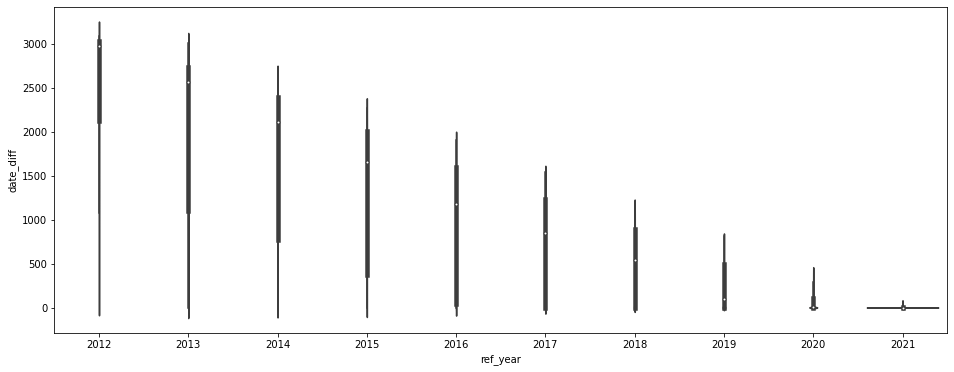

In [130]:
%matplotlib inline
plt.figure(figsize=(16, 6))
sns.violinplot(x='ref_year', y='date_diff', data=df)

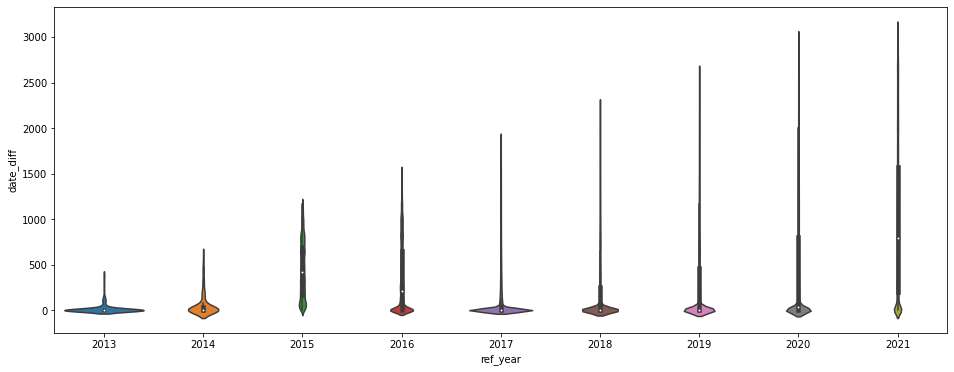

In [131]:
df['ref_year'] = df.last_update_date.dt.year

%matplotlib inline
plt.figure(figsize=(16, 6))
sns.violinplot(x='ref_year', y='date_diff', data=df)

In [132]:
tz = pytz.timezone('UTC')
NOW = datetime.now(tz)

df['date_stale'] = (NOW - df.last_update_date) / np.timedelta64(1, 'D')
df.date_stale.describe()

count    1.098965e+07
mean     4.938181e+02
std      5.441444e+02
min      2.592081e+01
25%      7.723253e+01
50%      2.568040e+02
75%      7.197954e+02
max      2.965898e+03
Name: date_stale, dtype: float64

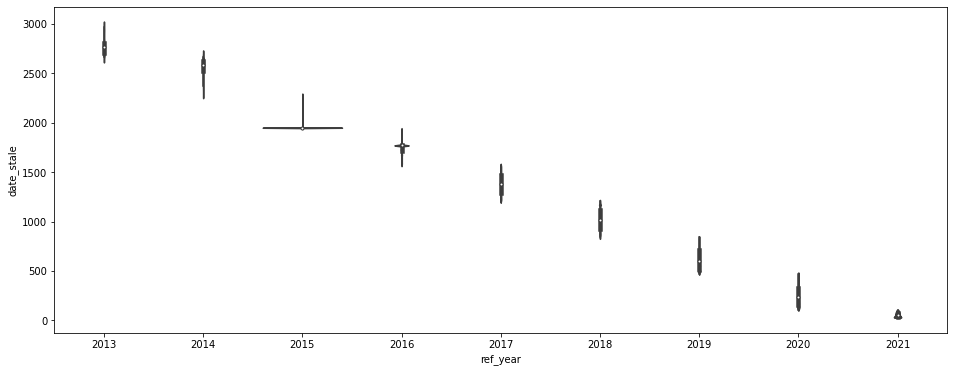

In [133]:
%matplotlib inline
plt.figure(figsize=(16, 6))
sns.violinplot(x='ref_year', y='date_stale', data=df)

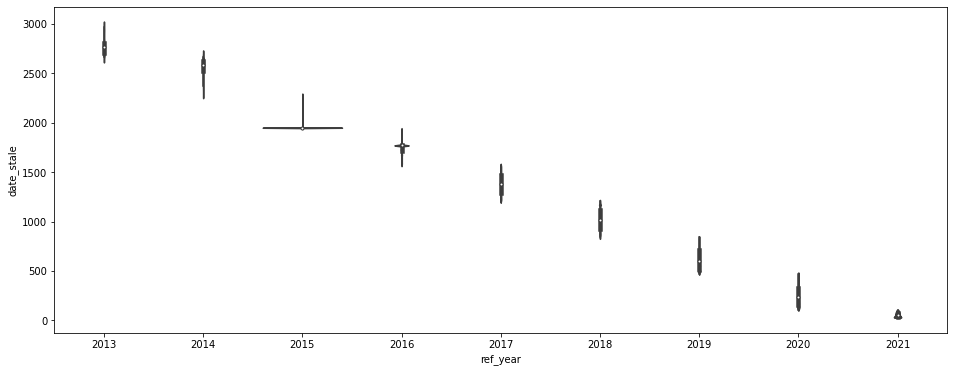

In [134]:
df['ref_year'] = df.last_update_date.dt.year

%matplotlib inline
plt.figure(figsize=(16, 6))
sns.violinplot(x='ref_year', y='date_stale', data=df)

# All VS all colleration

In [135]:
fig = px.imshow(df.select_dtypes(include=['bool','number']).fillna(-1).corr())
fig.show()

In [136]:
fig = px.imshow(df[df.biography.notna()].select_dtypes(include=['bool','number']).fillna(-1).corr())
fig.show()

In [137]:
fig = px.imshow(df[df.label == True].select_dtypes(include=['bool','number']).fillna(-1).corr())
fig.show()

In [138]:
# df[['verified_email', 
#     'verified_primary_email', 
#     'n_works', 
#     'n_doi',
#     'n_arxiv', 
#     'n_pmc', 
#     'n_other_pids', 
#     'n_emails', 
#     'n_urls', 
#     'n_ids', 
#     'n_keywords', 
#     'n_employment', 
#     'n_education', 
#     'label']].to_pickle('../data/processed/features.pkl')

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10989649 entries, 0 to 10989648
Data columns (total 41 columns):
 #   Column                  Dtype              
---  ------                  -----              
 0   orcid                   object             
 1   verified_email          bool               
 2   verified_primary_email  bool               
 3   given_names             string             
 4   family_name             string             
 5   biography               string             
 6   other_names             object             
 7   primary_email           string             
 8   keywords                object             
 9   external_ids            object             
 10  education               object             
 11  employment              object             
 12  n_works                 Int16              
 13  works_source            object             
 14  activation_date         datetime64[ns, UTC]
 15  last_update_date        datetime64[ns, UTC]
 16